<a href="https://colab.research.google.com/github/sushirito/Hg2/blob/main/2D_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

cuda
Epoch: 100, MSE: 0.026761
Epoch: 200, MSE: 0.024696
Epoch: 300, MSE: 0.022623
Epoch: 400, MSE: 0.018416
Epoch: 500, MSE: 0.013206
total training time in minutes: 0.37293312946955365


<ipython-input-6-438c1a6acc09>:152: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best', frameon=True, fontsize=22)
<ipython-input-6-438c1a6acc09>:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_on

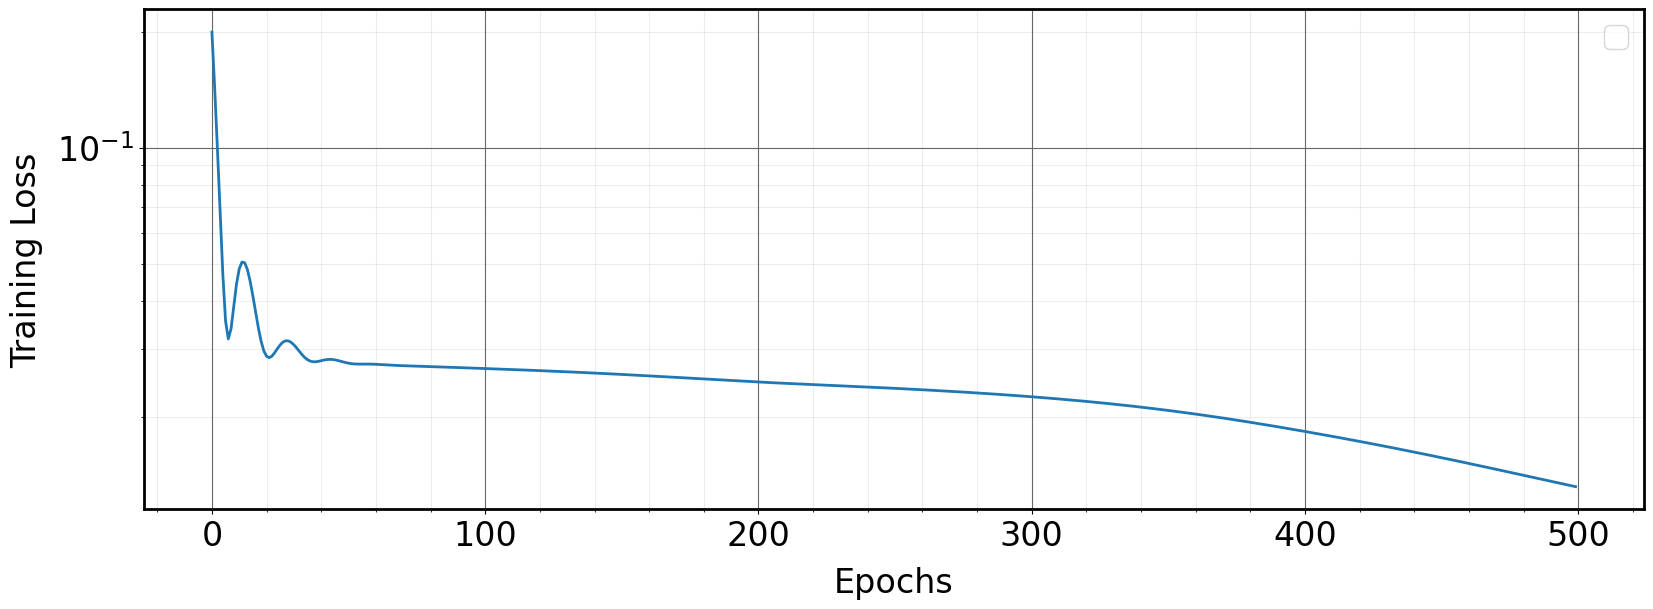

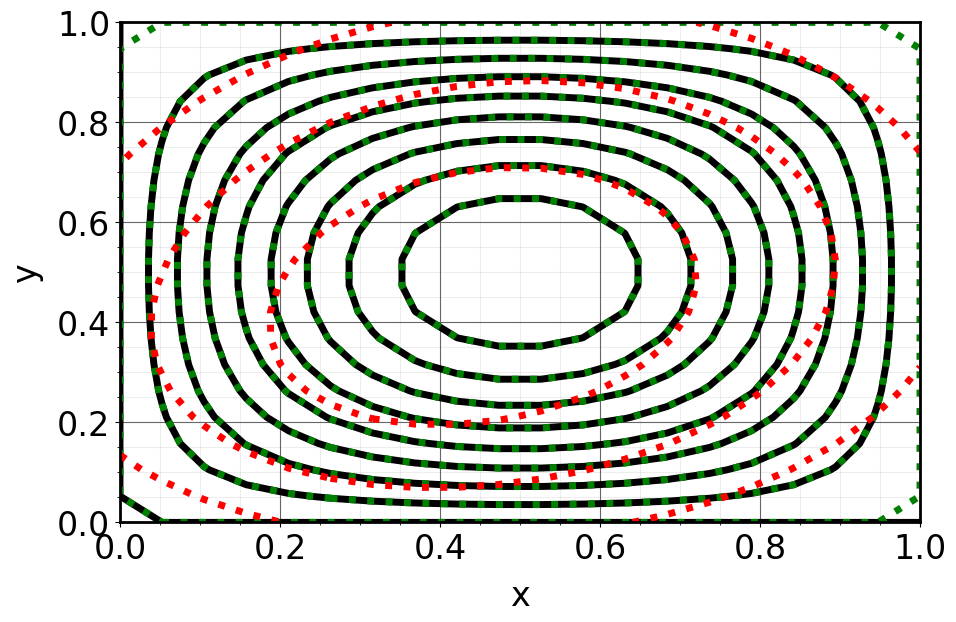

In [6]:
!pip install pyDOE
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 24
plt.rcParams['axes.linewidth'] = 2
import torch
import torch.nn as nn
from pyDOE import *
from scipy.integrate import odeint
import time
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
torch.__version__
torch.manual_seed(31)
np.random.seed(31)
class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)
    def forward(self, x):
        for i in range(len(self.linears)-1):
            x = self.activation(self.linears[i](x))
        x = self.linears[-1](x)
        return x
    def loss_bc_init(self, x, y):
        loss_u = self.loss_function(self.forward(x), y)
        return loss_u
    def loss_initernal(self, x_train):
        x_train.requires_grad = True
        p = self.forward(x_train)
        u_g = gradients(p, x_train)[0]
        u_x, u_y, u_t = u_g[:, [0]], u_g[:, [1]], u_g[:, [2]]
        u_xx = gradients(u_x, x_train)[0][:, [0]]
        u_yy = gradients(u_y, x_train)[0][:, [1]]
        pde = u_t - D * (u_xx + u_yy)
        loss_pde = pde.pow(2).mean()
        return loss_pde
    def loss(self, x, y, x_to_train_f):
        loss_u = self.loss_bc_init(init_cond_train, u_init_cond_train)
        loss_f = self.loss_initernal(f_train)
        loss_val = loss_u + loss_f
        return loss_val
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)
def nptoTensor(data):
    return torch.from_numpy(data).to(device).float()
def u_2d(x_2d):
    return np.sin(np.pi * x_2d[:, 0]) * np.sin(np.pi * x_2d[:, 1])
def trainingdata(Nx, Ny, Nt, Nf, Nu):
    x = np.linspace(0, 1, Nx)
    y = np.linspace(0, 1, Ny)
    t = np.linspace(0, 1, Nt)
    X, Y = np.meshgrid(x, y)
    x_2d = np.concatenate((X.flatten()[:, None], Y.flatten()[:, None]), axis=1)
    t_2d = np.zeros((Nx * Ny, 1))
    intial_condition = np.concatenate((x_2d, t_2d), axis=1)
    u_inital = u_2d(x_2d)[:, None]
    lower_x = np.concatenate((X[:, 0][:, None], Y[:, 0][:, None]), axis=1)
    lower_x = np.tile(lower_x, [int(Nt / Nx), 1])
    lower_x = np.concatenate((lower_x, t[:, None]), axis=1)
    u_lower_x_bc = np.zeros(Nt)[:, None]
    upper_x = np.concatenate((X[:, -1][:, None], Y[:, 0][:, None]), axis=1)
    upper_x = np.tile(upper_x, [int(Nt / Nx), 1])
    upper_x = np.concatenate((upper_x, t[:, None]), axis=1)
    u_upper_x_bc = np.zeros(Nt)[:, None]
    right_y = np.concatenate((X[0, :][:, None], Y[-1, :][:, None]), axis=1)
    right_y = np.tile(right_y, [int(Nt / Nx), 1])
    right_y = np.concatenate((right_y, t[:, None]), axis=1)
    u_right_y_bc = np.zeros(Nt)[:, None]
    left_y = np.concatenate((X[0, :][:, None], Y[0, :][:, None]), axis=1)
    left_y = np.tile(left_y, [int(Nt / Nx), 1])
    left_y = np.concatenate((left_y, t[:, None]), axis=1)
    u_left_y_bc = np.zeros(Nt)[:, None]
    all_Init_bcs = np.vstack([intial_condition, lower_x, upper_x, right_y, left_y])
    all_u_init_bcs = np.vstack([u_inital, u_lower_x_bc, u_upper_x_bc, u_right_y_bc, u_left_y_bc])
    idx = np.random.choice(all_Init_bcs.shape[0], Nu, replace=False)
    all_Init_bcs = all_Init_bcs[idx, :]
    all_u_init_bcs = all_u_init_bcs[idx, :]
    f_train = lhs(3, Nf)
    f_train = np.vstack((f_train, all_Init_bcs))
    return all_Init_bcs, all_u_init_bcs, f_train
def trainingdata(Nx, Ny, Nt, Nf, Nu):
    x = np.linspace(0, 1, Nx)
    y = np.linspace(0, 1, Ny)
    t = np.linspace(0, 1, Nt)
    X, Y = np.meshgrid(x, y)
    x_2d = np.concatenate((X.flatten()[:, None], Y.flatten()[:, None]), axis=1)
    t_2d = np.zeros((Nx * Ny, 1))
    intial_condition = np.concatenate((x_2d, t_2d), axis=1)
    u_inital = u_2d(x_2d)[:, None]
    lower_x = np.concatenate((X[:, 0][:, None], Y[:, 0][:, None]), axis=1)
    upper_x = np.concatenate((X[:, -1][:, None], Y[:, 0][:, None]), axis=1)
    right_y = np.concatenate((X[0, :][:, None], Y[-1, :][:, None]), axis=1)
    left_y = np.concatenate((X[0, :][:, None], Y[0, :][:, None]), axis=1)
    x_bound = np.vstack([lower_x, upper_x, right_y, left_y])
    x_bound_ext = np.tile(x_bound, [Nt, 1])
    t_bound_ext = np.tile(t[:, None], [Nx * 4, 1])
    xt_bound_ext = np.concatenate((x_bound_ext, t_bound_ext), axis=1)
    u_bound_ext = np.zeros((Nx * 4 * Nt))[:, None]
    all_Init_bcs = np.vstack([intial_condition, xt_bound_ext])
    all_u_init_bcs = np.vstack([u_inital, u_bound_ext])
    ldx = np.random.permutation(all_Init_bcs.shape[0])
    all_Init_bcs = all_Init_bcs[ldx]
    all_u_init_bcs = all_u_init_bcs[ldx]
    f_train = lhs(3, Nf)
    f_train = np.vstack((f_train, all_Init_bcs))
    return all_Init_bcs, all_u_init_bcs, f_train
N_u = 500
N_x = 30
N_y = 30
N_t = 50
N_f = 10000
init_cond_train_np_array, u_init_cond_train_np_array, f_train_np_array = trainingdata(N_x, N_y, N_t, N_f, N_u)
init_cond_train = nptoTensor(init_cond_train_np_array)
u_init_cond_train = nptoTensor(u_init_cond_train_np_array)
f_train = nptoTensor(f_train_np_array)
D = 0.1
neurons = 50
layers = np.array([3, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, 1])
mlp = MLP(layers).to(device)
step_size = 10000
gamma = 0.1
A_hist = []
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
max_iter = 500
tic = time.time()
for i in range(max_iter):
    loss = mlp.loss(init_cond_train, u_init_cond_train, f_train)
    A_hist.append([i, loss.detach().cpu().item()])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i + 1) % 100 == 0:
        print("Epoch: {}, MSE: {:.6f}".format((i + 1), loss.detach().cpu().item()))
toc = time.time()
print(f'total training time in minutes: {(toc - tic) / 60}')
A_hist = np.array(A_hist)
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.grid(visible=True, which='major', color='#666666', linestyle='-')
ax.minorticks_on()
ax.grid(visible=True, which='minor', color='#555555', linestyle='-', alpha=0.1)
ax.plot(A_hist[:, 0], A_hist[:, 1], linewidth=2, label='')
ax.legend(loc='best', frameon=True, fontsize=22)
ax.semilogy()
ax.set_xlabel('Epochs', labelpad=10)
ax.set_ylabel('Training Loss', labelpad=10)
path = '2-Diffusion_PDE4.pth'
torch.save(mlp.state_dict(), path)
path = '/content/2-Diffusion_PDE4.pth'
mlp.load_state_dict(torch.load(path))
mlp.eval()
model = MLP(layers)
state_dict = torch.load(path)
model.load_state_dict(state_dict)
model.eval()
example = torch.rand([1, 3])
traced_script_module = torch.jit.trace(model, example)
torch.jit.save(traced_script_module, "2D-Diffusion_PDE.pt")
loaded = torch.jit.load("2D-Diffusion_PDE.pt")
def build_mesh(N, t):
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    _t = np.array([t])
    m = np.meshgrid(x, y, _t)
    m = np.stack(m, -1).reshape(-1, 3)
    return x, y, m
def build_mesh1(N, t):
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    _t = np.array([t])
    x, y, t = np.meshgrid(x, y, _t)
    return x, y, t
n = 20
t = 0
def central_difference():
    return u[n][i][j] + delta_t * (alpha * (u[n][i+1][j] + u[n][i-1][j] + u[n][i][j+1] + u[n][i][j-1] - 4 * u[n][i][j]) / (delta_x)**2)
def initial(x, y):
    x = x[1:-1]
    y = y[1:-1]
    x, y = np.meshgrid(x, y)
    return np.sin(np.pi * x) * np.sin(np.pi * y)
points_in_x = 20
points_in_y = 20
alpha = 0.1
x = np.linspace(0, 1, points_in_x)
delta_x = x[1] - x[0]
y = np.linspace(0, 1, points_in_x)
delta_y = y[1] - y[0]
delta_t = 0.5 * (delta_x**2 * delta_y**2) / ((delta_x**2 + delta_y**2) * alpha)
points_in_t = int(1. / delta_t)
t = np.linspace(0, 1, points_in_t)
u = np.zeros((len(t), len(x), len(y)))
u[:, 0, :] = 0
u[:, len(x) - 1, :] = 0
u[:, :, 0] = 0
u[:, :, len(y) - 1] = 0
u[0, 1:len(x) - 1, 1:len(y) - 1] = initial(x, y)
for n in range(0, len(t) - 1):
    for i in range(1, len(x) - 1):
        for j in range(1, len(y) - 1):
            u[n + 1][i][j] = central_difference()
n = 20
def build_mesh(N, t):
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    _t = np.array([t])
    m = np.meshgrid(x, y, _t)
    m = np.stack(m, -1).reshape(-1, 3)
    return x, y, m
def build_mesh1(N, t):
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    _t = np.array([t])
    x, y, t = np.meshgrid(x, y, _t)
    return x, y, t
x1, y1, m1 = build_mesh(n, 0)
x2, y2, m2 = build_mesh(n, 0.25)
x3, y3, m3 = build_mesh(n, 0.5)
x4, y4, m4 = build_mesh(n, 0.75)
x5, y5, m5 = build_mesh(n, 1)
xe1, ye1, te1 = build_mesh1(n, 0)
xe2, ye2, te2 = build_mesh1(n, 0.25)
xe3, ye3, te3 = build_mesh1(n, 0.5)
xe4, ye4, te4 = build_mesh1(n, 0.75)
xe5, ye5, te5 = build_mesh1(n, 1)
def eval_model(m):
    mlp.eval()
    with torch.no_grad():
        p = mlp(torch.tensor(m).float().to(device)).cpu().numpy()
    return np.abs(p)
p1 = eval_model(m1)
p2 = eval_model(m2)
p3 = eval_model(m3)
p4 = eval_model(m4)
p5 = eval_model(m5)
def plot_model(x, y, p, x1, y1, t, u_fdm):
    pe = np.sin(np.pi * y1) * np.sin(np.pi * x1) * np.exp((-.1 * t) * (2 * np.pi**2))
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_axes([0, 0, 1, 1])
    img1 = ax.contour(x, y, pe.reshape(-1, n), linewidths=5, levels=np.linspace(0, 1, 10), colors='k', linestyles='solid')
    img2 = ax.contour(x, y, u_fdm.reshape(-1, n), linewidths=5, levels=np.linspace(0, 1, 10), colors='green', linestyles='dotted')
    img3 = ax.contour(x, y, p.reshape(-1, n), linewidths=5, levels=np.linspace(0, 1, 10), colors='red', linestyles='dotted')
    ax.grid(visible=True, which='major', color='#666666', linestyle='-')
    ax.minorticks_on()
    ax.grid(visible=True, which='minor', color='#555555', linestyle='-', alpha=0.1)
    ax.set_xlabel('x', labelpad=10)
    ax.set_ylabel('y', labelpad=10)
plot_model(x1, y1, p1, xe1, ye1, te1, u[0, :])
